In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [2]:


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './basic_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


['ants', 'bees']


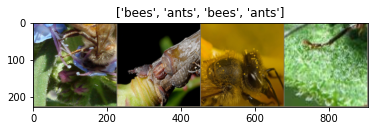

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j-1]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft = models.mnasnet1_0()
#num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
#model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.7974 Acc: 0.4836
val Loss: 6.6393 Acc: 0.5425

Epoch 1/9
----------
train Loss: 0.7664 Acc: 0.5287
val Loss: 6.4809 Acc: 0.4575

Epoch 2/9
----------
train Loss: 0.7254 Acc: 0.5410
val Loss: 6.3266 Acc: 0.4575

Epoch 3/9
----------
train Loss: 0.7162 Acc: 0.6025
val Loss: 6.1739 Acc: 0.5425

Epoch 4/9
----------
train Loss: 0.8051 Acc: 0.4754
val Loss: 6.0307 Acc: 0.5425

Epoch 5/9
----------
train Loss: 0.7575 Acc: 0.5574
val Loss: 5.8908 Acc: 0.4575

Epoch 6/9
----------
train Loss: 0.7272 Acc: 0.5820
val Loss: 5.7516 Acc: 0.4575

Epoch 7/9
----------
train Loss: 0.7174 Acc: 0.5574
val Loss: 5.6171 Acc: 0.5425

Epoch 8/9
----------
train Loss: 0.6476 Acc: 0.5779
val Loss: 5.4876 Acc: 0.5425

Epoch 9/9
----------
train Loss: 0.6538 Acc: 0.6066
val Loss: 5.3641 Acc: 0.5425

Training complete in 3m 37s
Best val Acc: 0.542484


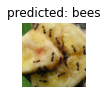

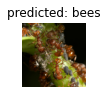

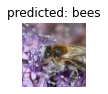

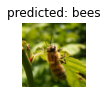

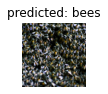

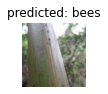

In [8]:

visualize_model(model_ft)


In [26]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

SVG(model_to_dot(model_ft, show_shapes=True).create(prog='dot', format='svg'))

AttributeError: 'MNASNet' object has no attribute 'built'

In [13]:
from torchsummaryX import summary
model= models.mnasnet1_0()
summary(model, torch.zeros((1,3,224,224)))

                                           Kernel Shape       Output Shape  \
Layer                                                                        
0_layers.Conv2d_0                         [3, 32, 3, 3]  [1, 32, 112, 112]   
1_layers.BatchNorm2d_1                             [32]  [1, 32, 112, 112]   
2_layers.ReLU_2                                       -  [1, 32, 112, 112]   
3_layers.Conv2d_3                         [1, 32, 3, 3]  [1, 32, 112, 112]   
4_layers.BatchNorm2d_4                             [32]  [1, 32, 112, 112]   
5_layers.ReLU_5                                       -  [1, 32, 112, 112]   
6_layers.Conv2d_6                        [32, 16, 1, 1]  [1, 16, 112, 112]   
7_layers.BatchNorm2d_7                             [16]  [1, 16, 112, 112]   
8_layers.8.0.layers.Conv2d_0             [16, 48, 1, 1]  [1, 48, 112, 112]   
9_layers.8.0.layers.BatchNorm2d_1                  [48]  [1, 48, 112, 112]   
10_layers.8.0.layers.ReLU_2                           -  [1, 48,

C:\Users\user\virtual_env\study\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_layers.Conv2d_0,"[3, 32, 3, 3]","[1, 32, 112, 112]",864.0,10838016.0
1_layers.BatchNorm2d_1,[32],"[1, 32, 112, 112]",64.0,32.0
2_layers.ReLU_2,-,"[1, 32, 112, 112]",NaN,NaN
3_layers.Conv2d_3,"[1, 32, 3, 3]","[1, 32, 112, 112]",288.0,3612672.0
4_layers.BatchNorm2d_4,[32],"[1, 32, 112, 112]",64.0,32.0
...,...,...,...,...
136_layers.Conv2d_14,"[320, 1280, 1, 1]","[1, 1280, 7, 7]",409600.0,20070400.0
137_layers.BatchNorm2d_15,[1280],"[1, 1280, 7, 7]",2560.0,1280.0
138_layers.ReLU_16,-,"[1, 1280, 7, 7]",NaN,NaN


In [18]:
from torchsummaryX import summary
model= models.mnasnet1_0(pretrained=True)
summary(model, torch.zeros((1,3,256,256)))

                                           Kernel Shape       Output Shape  \
Layer                                                                        
0_layers.Conv2d_0                         [3, 32, 3, 3]  [1, 32, 128, 128]   
1_layers.BatchNorm2d_1                             [32]  [1, 32, 128, 128]   
2_layers.ReLU_2                                       -  [1, 32, 128, 128]   
3_layers.Conv2d_3                         [1, 32, 3, 3]  [1, 32, 128, 128]   
4_layers.BatchNorm2d_4                             [32]  [1, 32, 128, 128]   
5_layers.ReLU_5                                       -  [1, 32, 128, 128]   
6_layers.Conv2d_6                        [32, 16, 1, 1]  [1, 16, 128, 128]   
7_layers.BatchNorm2d_7                             [16]  [1, 16, 128, 128]   
8_layers.8.0.layers.Conv2d_0             [16, 48, 1, 1]  [1, 48, 128, 128]   
9_layers.8.0.layers.BatchNorm2d_1                  [48]  [1, 48, 128, 128]   
10_layers.8.0.layers.ReLU_2                           -  [1, 48,

C:\Users\user\virtual_env\study\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_layers.Conv2d_0,"[3, 32, 3, 3]","[1, 32, 128, 128]",864.0,14155776.0
1_layers.BatchNorm2d_1,[32],"[1, 32, 128, 128]",64.0,32.0
2_layers.ReLU_2,-,"[1, 32, 128, 128]",NaN,NaN
3_layers.Conv2d_3,"[1, 32, 3, 3]","[1, 32, 128, 128]",288.0,4718592.0
4_layers.BatchNorm2d_4,[32],"[1, 32, 128, 128]",64.0,32.0
...,...,...,...,...
136_layers.Conv2d_14,"[320, 1280, 1, 1]","[1, 1280, 8, 8]",409600.0,26214400.0
137_layers.BatchNorm2d_15,[1280],"[1, 1280, 8, 8]",2560.0,1280.0
138_layers.ReLU_16,-,"[1, 1280, 8, 8]",NaN,NaN


In [19]:
from torchsummaryX import summary
model= models.mnasnet1_0(pretrained=False)
summary(model, torch.zeros((1,3,256,256)))

                                           Kernel Shape       Output Shape  \
Layer                                                                        
0_layers.Conv2d_0                         [3, 32, 3, 3]  [1, 32, 128, 128]   
1_layers.BatchNorm2d_1                             [32]  [1, 32, 128, 128]   
2_layers.ReLU_2                                       -  [1, 32, 128, 128]   
3_layers.Conv2d_3                         [1, 32, 3, 3]  [1, 32, 128, 128]   
4_layers.BatchNorm2d_4                             [32]  [1, 32, 128, 128]   
5_layers.ReLU_5                                       -  [1, 32, 128, 128]   
6_layers.Conv2d_6                        [32, 16, 1, 1]  [1, 16, 128, 128]   
7_layers.BatchNorm2d_7                             [16]  [1, 16, 128, 128]   
8_layers.8.0.layers.Conv2d_0             [16, 48, 1, 1]  [1, 48, 128, 128]   
9_layers.8.0.layers.BatchNorm2d_1                  [48]  [1, 48, 128, 128]   
10_layers.8.0.layers.ReLU_2                           -  [1, 48,

C:\Users\user\virtual_env\study\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_layers.Conv2d_0,"[3, 32, 3, 3]","[1, 32, 128, 128]",864.0,14155776.0
1_layers.BatchNorm2d_1,[32],"[1, 32, 128, 128]",64.0,32.0
2_layers.ReLU_2,-,"[1, 32, 128, 128]",NaN,NaN
3_layers.Conv2d_3,"[1, 32, 3, 3]","[1, 32, 128, 128]",288.0,4718592.0
4_layers.BatchNorm2d_4,[32],"[1, 32, 128, 128]",64.0,32.0
...,...,...,...,...
136_layers.Conv2d_14,"[320, 1280, 1, 1]","[1, 1280, 8, 8]",409600.0,26214400.0
137_layers.BatchNorm2d_15,[1280],"[1, 1280, 8, 8]",2560.0,1280.0
138_layers.ReLU_16,-,"[1, 1280, 8, 8]",NaN,NaN
